### 第5天：TensorFlow2建立模型的三种方式之Function API

In [1]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import os
import shutil
plt.rcParams['font.family'] = 'SimHei' 
plt.rcParams['axes.unicode_minus']=False
print('tensorflow版本：', tf.__version__)
tf.keras.backend.clear_session()  

tensorflow版本： 2.1.0


tf.keras提供Function API(函数式创建模型接口)。下面对数据集CIFAR 10建立基于卷积神经网络CNN的的多分类模型。

### 1、数据准备

In [2]:
# 引入数据集，该数据集的获取方式已经集成，直接引入后，会自动下载数据集
from tensorflow.keras.datasets import cifar10
cifar10_data = cifar10.load_data()

cifar10数据集分为两部分，前一部分是训练数据集，数据条数60000条，数据包括训练特征、训练标签；后一部分是测试数据集，数据条数10000条，数据包括测试特征、测试标签。其中每一条特征数据是一个(32, 32, 3)的矩阵；标签就是图片中物品对应的数字，一共有10种物品。

In [3]:
(train_features, train_labels), (test_features, test_labels) = cifar10_data
print('训练数据集')
print('特征：类型{}, 维度{}'.format(type(train_features), train_features.shape))
print('标签：类型{}, 维度{}'.format(type(train_labels), train_labels.shape))
print('测试数据集')
print('特征：类型{}, 维度{}'.format(type(test_features), test_features.shape))
print('标签：类型{}, 维度{}'.format(type(test_labels), test_labels.shape))

训练数据集
特征：类型<class 'numpy.ndarray'>, 维度(50000, 32, 32, 3)
标签：类型<class 'numpy.ndarray'>, 维度(50000, 1)
测试数据集
特征：类型<class 'numpy.ndarray'>, 维度(10000, 32, 32, 3)
标签：类型<class 'numpy.ndarray'>, 维度(10000, 1)


In [4]:
# 下面给出数字和物品名称的对应关系字典
name_number_dict = {0: '飞机', 1: '汽车', 2: '鸟', 3: '猫', 
                    4: '鹿', 5: '狗', 6: '青蛙', 7: '马',
                    8: '船只', 9: '卡车'}

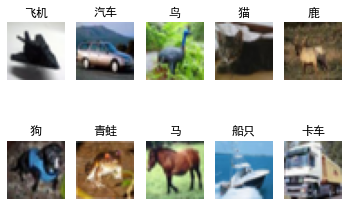

In [5]:
# 需要安装matplotlib：打开Anaconda Prompt，激活环境(activate tf2)，安装matplotlib(conda install matplotlib)
# 显示每一个类别的数据，分2行，一行5个
def showfig(features, label, b_dict=name_number_dict):
    # 每个类别均显示一张
    fig, axs = plt.subplots(2, 5)
    for i in range(10):
        n = list(label).index(i)
        axs[i // 5, i % 5].set_title('{}'.format(b_dict[i]))
        axs[i // 5, i % 5].set_axis_off()
        figdata = features[n]
        axs[i // 5, i % 5].imshow(figdata)  # 显示图片
        
showfig(train_features, train_labels)

In [6]:
# 看下训练数据中的标签的分布: 每一类别的样本个数是一样的
from collections import Counter
print('每个数字以及对应的图片个数：\n{}'.format(sorted(Counter(train_labels.T[0]).items(), key=lambda s:s[0])))

每个数字以及对应的图片个数：
[(0, 5000), (1, 5000), (2, 5000), (3, 5000), (4, 5000), (5, 5000), (6, 5000), (7, 5000), (8, 5000), (9, 5000)]


因为是构建的是神经网络模型，需要对数据进行归一化。因为图片的数字矩阵中的数字类型是无符号8位整数 uint8最大值为255，因此归一化需要除以255，也就是将数值变为[0, 1]范围内的数字。

In [7]:
# 归一化
trainfeatures = train_features / 255
testfeatures = test_features / 255

### 2、函数式创建模型 

按层顺序建立模型，建立的是线性叠加的模型。利用函数式API可以创建更灵活、更复杂的模型，例如可以建立具有非线性拓扑的、具有共享层的和具有多个输入或者输出的模型。现在以非线性的ResNet模型为例：

In [17]:
# 下面给出CNN模型的一些参数：
Epoch = 20  # 模型迭代的次数
Batch_Size = 64  # 批量训练的样本的个数
Out_Class = 10  # 输出的类别的个数,0-9共10类

In [59]:
### 建立模型
def build_cnn(name='CNN_CIFAR10'):
    # 输入层
    in_put = tf.keras.Input(shape=(32, 32, 3), name='INPUT')
    
    # 卷积层
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=[3,3], activation='relu', name='CONV_1')(in_put)
    # 卷积层
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=[3,3], activation='relu', name='CONV_2')(x)
    # 最大池化层
    block_1_output = tf.keras.layers.MaxPooling2D(pool_size=[3,3], name='MAXPOOL_1')(x)

    # 卷积层
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=[3,3], activation='relu', padding='same', name='CONV_3')(block_1_output)
    # 卷积层
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=[3,3], activation='relu', padding='same', name='CONV_4')(x)
    # 相加层，建立锁死
    block_2_output = tf.keras.layers.add([x, block_1_output], name='ADD_1')

    # 卷积层
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=[3,3], activation='relu', padding='same', name='CONV_5')(block_2_output)
    # 卷积层
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=[3,3], activation='relu', padding='same', name='CONV_6')(x)
    # 相加层
    block_3_output = tf.keras.layers.add([x, block_2_output], name='ADD_2')

    # 卷积层
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=[3,3], activation='relu',name='CONV_7')(block_3_output)
    # 池化层
    x = tf.keras.layers.GlobalAveragePooling2D(name='GAP_1')(x)
    # 全连接层
    x = tf.keras.layers.Dense(256, activation='relu', name='DENSE_1')(x)
    # 丢失层
    x = tf.keras.layers.Dropout(0.5, name='DROPOUT_1')(x)
    
    # 输出层
    out_put = tf.keras.layers.Dense(10, activation='softmax', name='OUTPUT', )(x)

    #  建立模型
    model = tf.keras.Model(inputs=in_put, outputs=out_put, name=name)
    # 模型编译
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model
# 建立模型
ResNet_Model = build_cnn()

In [60]:
# 模型结构描述
ResNet_Model.summary()

Model: "CNN_CIFAR10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
INPUT (InputLayer)              [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
CONV_1 (Conv2D)                 (None, 30, 30, 32)   896         INPUT[0][0]                      
__________________________________________________________________________________________________
CONV_2 (Conv2D)                 (None, 28, 28, 64)   18496       CONV_1[0][0]                     
__________________________________________________________________________________________________
MAXPOOL_1 (MaxPooling2D)        (None, 9, 9, 64)     0           CONV_2[0][0]                     
________________________________________________________________________________________

要展示网络结构图的话，需要在这个虚拟环境中安装pydot和pydot-ng。然后在订阅号发送'graphviz'，下载安装包。安装完成后将Graphviz的bin路径添加到环境变量Path中，重启jupyter notebook即可。

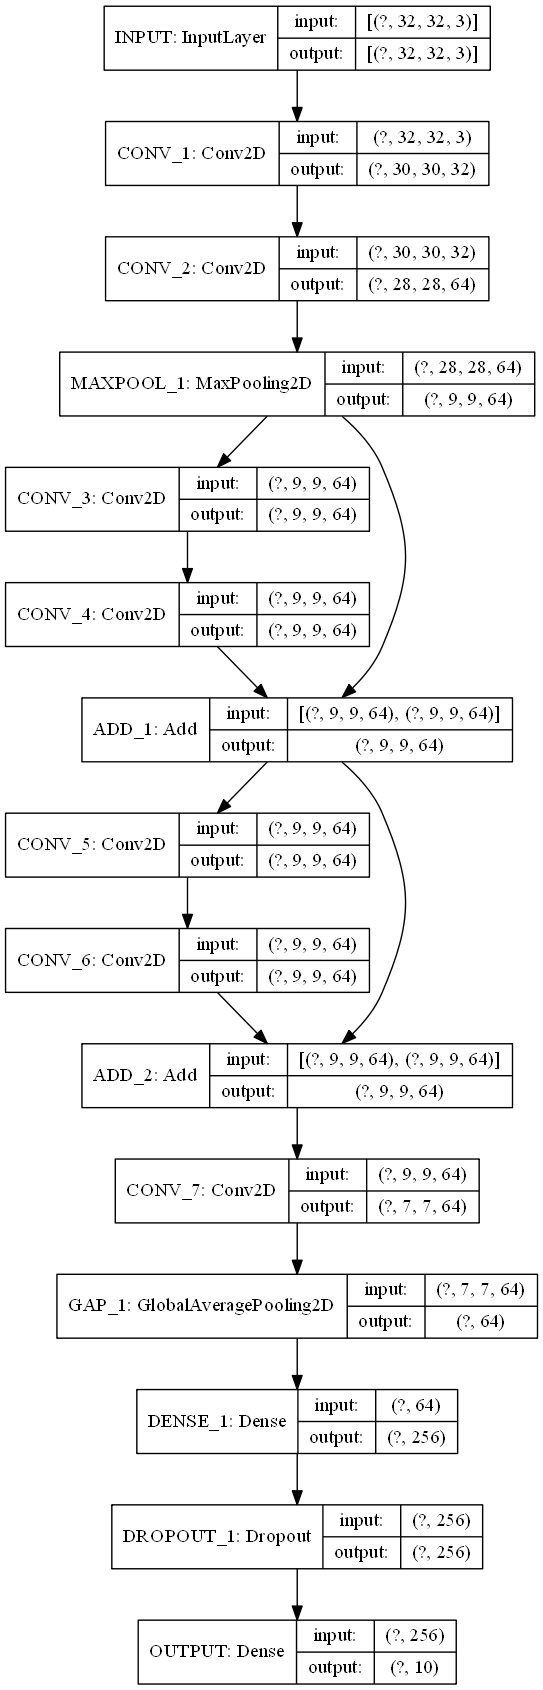

In [208]:
# 打印CNN的网络结构
tf.keras.utils.plot_model(ResNet_Model, to_file='CNN_Model.png', show_shapes=True, show_layer_names=True,rankdir='TB', dpi=100, expand_nested=True)

### 3、模型训练

In [62]:
# 模型回调保存
checkpoint_path = "./cp-{val_accuracy:.5f}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# 创建一个回调，保证验证数据集准确率最大
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, monitor='val_accuracy',
                                                 mode='max', verbose=2, save_best_only=True)

# 创建一个回调，记录训练过程中的数据
# 建立存储模型参数的文件夹

output_model_file = os.path.join('train_record')

if not os.path.exists(output_model_file):
    os.mkdir(output_model_file)
else:
    shutil.rmtree(output_model_file)
    os.mkdir(output_model_file)

# 创建一个回调，输出训练和验证数据集的误差曲线
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=output_model_file)

In [63]:
# 训练模型
resnet_model_history = ResNet_Model.fit(trainfeatures, train_labels.T[0], batch_size=Batch_Size, 
                 epochs=Epoch, verbose=2, validation_split=0.1, callbacks=[cp_callback, tensorboard_callback])


Train on 45000 samples, validate on 5000 samples
Epoch 1/20

Epoch 00001: val_accuracy improved from -inf to 0.41120, saving model to ./cp-0.41120.ckpt
45000/45000 - 161s - loss: 1.7483 - accuracy: 0.3183 - val_loss: 1.6517 - val_accuracy: 0.4112
Epoch 2/20

Epoch 00002: val_accuracy improved from 0.41120 to 0.61220, saving model to ./cp-0.61220.ckpt
45000/45000 - 156s - loss: 1.3144 - accuracy: 0.5162 - val_loss: 1.0695 - val_accuracy: 0.6122
Epoch 3/20

Epoch 00003: val_accuracy improved from 0.61220 to 0.65480, saving model to ./cp-0.65480.ckpt
45000/45000 - 155s - loss: 1.0701 - accuracy: 0.6151 - val_loss: 0.9414 - val_accuracy: 0.6548
Epoch 4/20

Epoch 00004: val_accuracy improved from 0.65480 to 0.72000, saving model to ./cp-0.72000.ckpt
45000/45000 - 173s - loss: 0.9271 - accuracy: 0.6691 - val_loss: 0.8060 - val_accuracy: 0.7200
Epoch 5/20

Epoch 00005: val_accuracy improved from 0.72000 to 0.74380, saving model to ./cp-0.74380.ckpt
45000/45000 - 186s - loss: 0.8332 - accuracy

### 4、加载模型，继续训练


In [64]:
# 建立一个同样结构的模型
resnet_model_new = build_cnn(name='CNN_CIFAR10_new')
# 选择之前训练比较好的模型
best_para = tf.train.latest_checkpoint(checkpoint_dir)
# 加载
resnet_model_new.load_weights(best_para)
# 继续训练
resnet_model_history_new = resnet_model_new.fit(trainfeatures, train_labels.T[0], batch_size=Batch_Size, 
                 epochs=10, verbose=2, validation_split=0.1, callbacks=[cp_callback, tensorboard_callback])


Train on 45000 samples, validate on 5000 samples
Epoch 1/10

Epoch 00001: val_accuracy did not improve from 0.80160
45000/45000 - 173s - loss: 0.3709 - accuracy: 0.8708 - val_loss: 0.6493 - val_accuracy: 0.7986
Epoch 2/10

Epoch 00002: val_accuracy did not improve from 0.80160
45000/45000 - 172s - loss: 0.3408 - accuracy: 0.8815 - val_loss: 0.7195 - val_accuracy: 0.7952
Epoch 3/10

Epoch 00003: val_accuracy did not improve from 0.80160
45000/45000 - 173s - loss: 0.3140 - accuracy: 0.8900 - val_loss: 0.7530 - val_accuracy: 0.7952
Epoch 4/10

Epoch 00004: val_accuracy did not improve from 0.80160
45000/45000 - 172s - loss: 0.3047 - accuracy: 0.8938 - val_loss: 0.7540 - val_accuracy: 0.7956
Epoch 5/10

Epoch 00005: val_accuracy did not improve from 0.80160
45000/45000 - 173s - loss: 0.2747 - accuracy: 0.9043 - val_loss: 0.7892 - val_accuracy: 0.7858
Epoch 6/10

Epoch 00006: val_accuracy did not improve from 0.80160
45000/45000 - 173s - loss: 0.2459 - accuracy: 0.9145 - val_loss: 0.8157 - 

### 5、训练过程图示

<Figure size 576x288 with 0 Axes>

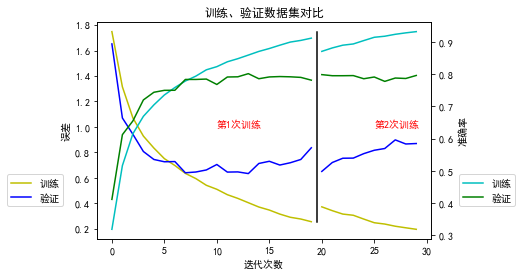

In [237]:
# 根据2个数字输出对应的颜色
def generate_c(n1, n2, n3):
    sum_n = n1+n2+n3
    return (n1/sum_n, n2/sum_n, n3/sum_n)

# 绘制两次训练过程中的训练数据和验证数据的成本、精确度
def plot_loss(model_history_list, c=['y', 'b', 'c', 'g']):
    # 绘图
    plt.figure(figsize=(8,4))
    # 绘制误差
    fig, ax1 = plt.subplots()
    # 遍历两次训练
    start_e = 0
    for i, k in enumerate(model_history_list):
        # 训练误差
        loss = k.history['loss']
        # 验证误差
        val_loss = k.history['val_loss']
        # 添加曲线
        if not i:
            ax1.plot(np.arange(len(loss)) + start_e, loss, c=c[0], label='训练')
            ax1.plot(np.arange(len(loss)) + start_e, val_loss, c=c[1], label='验证')
        else:
            ax1.plot(np.arange(len(loss)) + start_e, loss, c=c[0])
            ax1.plot(np.arange(len(loss)) + start_e, val_loss, c=c[1])   
        start_n = start_e
        start_e += len(loss)
        if i != len(model_history_list) - 1:
        # 添加训练阶段的线
            ax1.plot([start_e-0.5] * 2, [min(loss), max(loss)], c='k')
        # 添加训练段文字
        if i == 0:
            dd = (min(loss) + max(loss))/2
        ax1.text(start_e - len(loss) /2, dd, '第{}次训练'.format(i+1), color='red')
    # 图例弄到图像的外面
    ax1.legend(bbox_to_anchor=(-0.1, 0.3), borderaxespad=0.)    
    ax1.set_xlabel('迭代次数')
    ax1.set_ylabel('误差')
    ax1.tick_params(axis='y')
    
    ax2 = ax1.twinx() 
    #  遍历两次训练
    start_e = 0
    for i, k in enumerate(model_history_list):
        # 训练精度
        accuracy = k.history['accuracy']
        # 验证精度
        val_accuracy = k.history['val_accuracy']
        # 添加曲线
        if not i:
            ax2.plot(np.arange(len(accuracy)) + start_e, accuracy, c=c[2], label='训练')
            ax2.plot(np.arange(len(val_accuracy)) + start_e, val_accuracy, c=c[3], label='验证')
        else:
            ax2.plot(np.arange(len(accuracy)) + start_e, accuracy, c=c[2])
            ax2.plot(np.arange(len(val_accuracy)) + start_e, val_accuracy, c=c[3])
        start_e += len(accuracy)

    ax2.set_ylabel('准确率')
    ax2.tick_params(axis='y')
    
    plt.title('训练、验证数据集对比')
    ax2.legend(bbox_to_anchor=(1.25, 0.3), borderaxespad=0.)
    plt.show()

plot_loss([resnet_model_history, resnet_model_history_new])

### 6、模型评估

In [100]:
# 评估模型,按照模型最后的参数计算
test_loss, test_acc = resnet_model_new.evaluate(testfeatures, test_labels.T[0])

print('测试数据集成本：{:.8f},准确率{:.8f}%%'. format(test_loss, 100*test_acc))

10000/10000 [==============================] - 8s 816us/sample - loss: 0.9057 - accuracy: 0.7862
测试数据集成本：0.90570179,准确率78.61999869%%


### 7、模型预测

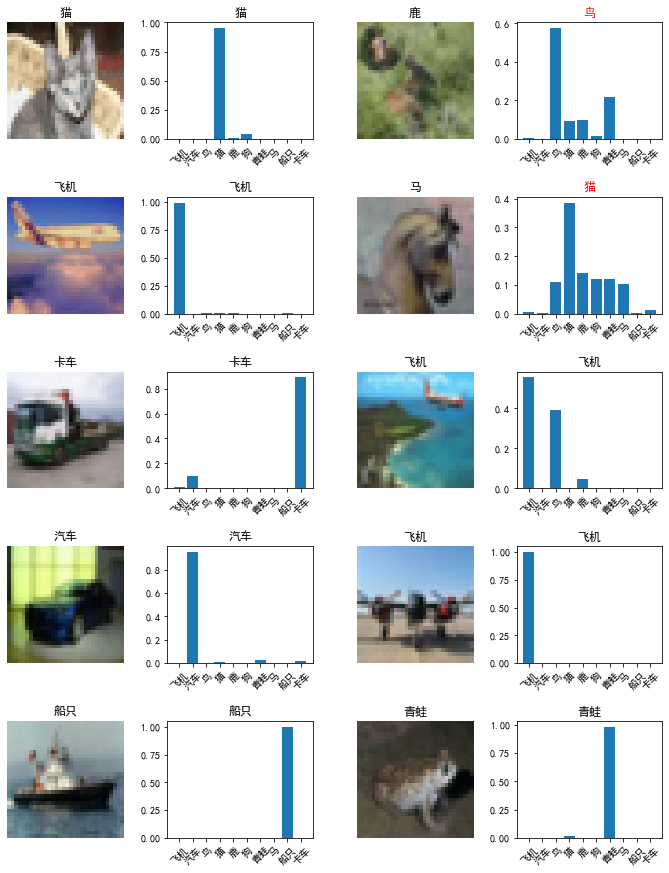

In [238]:
# 随机选取n条数据，显示原图片、真实标签，预测标签，以及预测得到的概率分布柱状图，对于识别错误的方框标红显示
N = 10
random_sign = np.random.choice(np.arange(len(testfeatures)), N, replace=False)

# 随机选取的数据
random_test_features = testfeatures[random_sign] # 特征数据
random_test_labels = test_labels[random_sign].T[0]

# 加载模型
# 建立一个同样结构的模型
resnet_model_predict = build_cnn(name='CNN_CIFAR10_predict')
# 选择之前训练比较好的模型
best_para = tf.train.latest_checkpoint(checkpoint_dir)
# 加载
resnet_model_predict.load_weights(best_para)
# 预测
predict_out = resnet_model_predict.predict(random_test_features)

# 输出图示
def plot_result(data_f, data_l, pre_out, sign_dict=name_number_dict, n=2):
    """
    data_f: 输入的特征数据，用于图像的展示
    data_l：特征数据对应的标签
    pre_out：模型预测得到的每个类别的概率值
    sign_dict：数字标签对应的物品名称
    n: 图中每行图片的个数
    """
    if len(data_f) % n == 0:
        rows = len(data_f) // n
    else:
        rows = len(data_f) // n + 1
    fig, axs = plt.subplots(rows, 2 * n, figsize=(n*6, rows*3))
    fig.subplots_adjust(hspace=0.5, wspace=0.2)
    # 根据概率得到输出的物品数字编号
    # 输出标签值
    predict_out_sign = tf.argmax(pre_out, axis=1).numpy()
    # 从数字0到数字9输出物品名称列表
    name_list = [h[1] for h in sorted(sign_dict.items(), key=lambda s: s[0])]
    # 开始绘图
    for index, value in enumerate(data_l):
        row, col = index//n, (index*2)%(2*n)
        if rows != 1:
            ax = axs[row, col]
            bx = axs[row, col + 1]
        else:
            ax = axs[col]
            bx = axs[col + 1]
        if row * n + index%n < len(data_f):
            # 首先绘制图像
            ax.imshow(data_f[index])
            # 标题
            ax.set_title('{}'.format(sign_dict[value]))
            ax.set_axis_off()

            # 然后绘制输出的概率分布图
            # 标题:不同的标红
            if sign_dict[value] != sign_dict[predict_out_sign[index]]:
                bx.set_title('{}'.format(sign_dict[predict_out_sign[index]]), color='red')
            else:
                bx.set_title('{}'.format(sign_dict[predict_out_sign[index]]))
            # 概率柱状图
            
            bx.bar(name_list, pre_out[index])
            labels = bx.get_xticklabels()
            plt.setp(labels, rotation=45)
    # 清除多余的图片
    for i in range(col+2, n*2):
        if rows == 1:
            axs[i].set_axis_off()
        else:
            axs[row, i].set_axis_off()
    plt.savefig('predict_result.png', dpi=200)

plot_result(random_test_features, random_test_labels, predict_out)    
    